## HW2 - Sentiment Analysis using CNN and RNN.
### Name - Atharv Subhekar
### CWID - 20015840

In [83]:
# importing required libraries
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
import keras
from keras import models
from keras.models import Sequential
from keras.layers import LSTM, Activation, Dropout, Dense, Input, Embedding, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.preprocessing import sequence
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import gensim.downloader as api
import random
from sklearn.metrics import classification_report
from sklearn import metrics
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data Preprocessing


#### Data Preprocessing
In Data Preprocessing we have a function to tokenize each sentence into separate works called tokens.

In [50]:
def tokenize(text):
    '''
    tokenize(text) accepts a sentence (i.e., text parameter) as an input
    '''
    stop_words = set(stopwords.words('english'))

    # splits the sentence into a list of tokens by space (including tab, new line)
    text = re.sub(r'[0-9]+', '', text)
    split_text = re.split(r' |\n', text)

    token_new_list = []

    # removes the leading/trailing punctuations or spaces of each token, if any
    puncts = string.punctuation
    for token in split_text:
        if token != '':
            token_new = token.strip(puncts)
            token_new_list.append(token_new.lower())
    # removes the stop words using NLTK stopword corpus
    filtered_sentence = []
    for w in token_new_list:
      if w not in stop_words:
        filtered_sentence.append(w)
    #vocab = [token: filtered_sentence.count(token) for token in filtered_sentence]
    vocab = [token for token in filtered_sentence]
    return vocab

In [51]:
# Removing all the stop words and converting all the labels in binary labels
# Data preprocessing
amazonReviews = pd.read_csv('amazon_reviews.csv')
amazonReviews = amazonReviews.dropna()
amazonReviews.head(5)

# lowercasing
amazonReviews["reviewText"] = amazonReviews["reviewText"].str.lower()

# removing punctuations
amazonReviews['reviewText'] = amazonReviews['reviewText'].str.translate(str.maketrans(' ', ' ', string.punctuation))

# removing stopwords
stop_words = set(stopwords.words('english'))
amazonReviews['reviewText'] = amazonReviews['reviewText'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# removing numbers
amazonReviews['reviewText'] = amazonReviews['reviewText'].str.replace('\d+', '')

# tokenizing
amazonReviews['reviewText'] = amazonReviews['reviewText'].apply(lambda x: tokenize(x))

# changing labels
amazonReviews['overall'] = amazonReviews['overall'].apply(lambda x: 1 if x == 4 or x == 5 else 0)

<ipython-input-51-5040d86c2247>:18: FutureWarning: The default value of regex will change from True to False in a future version.
  amazonReviews['reviewText'] = amazonReviews['reviewText'].str.replace('\d+', '')


In [52]:
amazonReviews.head()


,overall,reviewText
0,1,[issues]
1,1,"[purchased, device, worked, advertised, never,..."
2,1,"[works, expected, sprung, higher, capacity, th..."
3,1,"[think, worked, greathad, diff, bran, gb, card..."
4,1,"[bought, retail, packaging, arrived, legit, or..."


### Data Split
Splitting the data into training set, validation set and testing set with size 80%, 10% and 10% respectively.*italicized text*

In [53]:
features = amazonReviews['reviewText']
target = amazonReviews['overall']
# Splitting the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=8)
# Splitting X_train and y_trian into train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=8)

### Data Statistics
For data statistics I tokenized and stored all the words in a single list and computed basic stats.

In [54]:
all_words = []
for i in features:
  for j in i:
    all_words.append(j)

In [55]:
def counters(all_words):
  token_count = []
  for tokens in all_words:
    token_count.append(len(tokens))

  return token_count

In [56]:
# Number of data samples and their labels
print('Lenght of training set values - ',len(X_train))
print('Lenght of training set labels - ',len(y_train))
print('Lenght of testing set values - ',len(X_test))
print('Lenght of testing set labels - ',len(y_test))
print('Lenght of validation set values - ',len(X_val))
print('Lenght of validation set labels - ',len(y_val))

Lenght of training set values -  3979
Lenght of training set labels -  3979
Lenght of testing set values -  492
Lenght of testing set labels -  492
Lenght of validation set values -  443
Lenght of validation set labels -  443


In [57]:
# Number of tokens in X_train
token_count = counters(X_train)
print('Total number of tokens -', sum(token_count))
print('Maximum number of tokens in all the reviews in X_train -',max(token_count))
print('Minimum number of tokens in all the reviews in X_train -',min(token_count))
print('Average number of tokens in all the reviews in X_train -',sum(token_count) / len(token_count))

Total number of tokens - 102763
Maximum number of tokens in all the reviews in X_train - 781
Minimum number of tokens in all the reviews in X_train - 1
Average number of tokens in all the reviews in X_train - 25.826338275948732


In [58]:
# Number of tokens in X_train
token_count = counters(X_test)
print('Total number of tokens -', sum(token_count))
print('Maximum number of tokens in all the reviews in X_train -',max(token_count))
print('Minimum number of tokens in all the reviews in X_train -',min(token_count))
print('Average number of tokens in all the reviews in X_train -',sum(token_count) / len(token_count))

Total number of tokens - 11577
Maximum number of tokens in all the reviews in X_train - 240
Minimum number of tokens in all the reviews in X_train - 1
Average number of tokens in all the reviews in X_train - 23.53048780487805


In [59]:
# Number of tokens in X_val
token_count = counters(X_val)
print('Total number of tokens -', sum(token_count))
print('Maximum number of tokens in all the reviews in X_train -',max(token_count))
print('Minimum number of tokens in all the reviews in X_train -',min(token_count))
print('Average number of tokens in all the reviews in X_train -',sum(token_count) / len(token_count))

Total number of tokens - 10422
Maximum number of tokens in all the reviews in X_train - 141
Minimum number of tokens in all the reviews in X_train - 1
Average number of tokens in all the reviews in X_train - 23.525959367945823


## Recurrent Neural Network using Keras embedding layer
Implementing Simple RNN using Keras Embedding layer which take text to sequence as input and creates word embedding in the model itself.

In [60]:
# Function to get a list of all the unique words in the corpus excluding stopwords.
def get_vocab(corpus):
  # considering that we are passing the entire dataset i.e. along with the ratings
  vocabulary = [word for review in corpus["reviewText"] for word in review]
  return sorted(set(vocabulary))

In [61]:
# Function to store all the unique words in the corpus
def word2index(corpus):
  # obtaining the vocabulary
  vocab = get_vocab(corpus)
  # creating word2index
  word2index = {}
  for i in range(len(vocab)):
    word2index[vocab[i]] = i
  return word2index

In [62]:
word2index = word2index(amazonReviews)

In [63]:
# allocating space to construct review sequences
review_seq = []
for review in features:
  currReview = []
  for token in review:
    try:
      idx = word2index[token]
      currReview.append(idx)
    except KeyError:
      currReview.append(0)

  review_seq.append(currReview)

In [64]:
# Splitting the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(review_seq, target, test_size=0.1, random_state=8)
# Splitting X_train and y_trian into train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=8)

In [65]:
seq_length = 30
X_train_seq = sequence.pad_sequences(X_train, maxlen = seq_length)
X_val_seq = sequence.pad_sequences(X_val, maxlen = seq_length)
X_test_seq = sequence.pad_sequences(X_test, maxlen = seq_length)

In [66]:
# Defining the model
model = Sequential()
model.add(Embedding(len(word2index) ,10, input_length = seq_length))
model.add(LSTM(128 , dropout = 0.25, recurrent_dropout = 0.25))
model.add(Dense(1, activation = 'sigmoid' ))
# Summarizing the model to check the number of parameters and size of the model.
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 10)            96970     
                                                                 
 lstm_2 (LSTM)               (None, 128)               71168     
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 168267 (657.29 KB)
Trainable params: 168267 (657.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [67]:
# Compiling the model using Stochastic GD as optimizer and binary cross entropy loss as this is binary classification problem
model.compile( optimizer = "sgd" , loss = 'binary_crossentropy' , metrics = ['accuracy'] )

In [68]:
# Fitting the model on the training data and testing the model for accuracy of validation data.
history = model.fit(X_train_seq , y_train, epochs = 5, validation_data =(X_val_seq, y_val) , verbose = 1)

Epoch 1/5
125/125 [==============================] - 16s 96ms/step - loss: 0.4901 - accuracy: 0.9007 - val_loss: 0.3638 - val_accuracy: 0.9052
Epoch 2/5
125/125 [==============================] - 10s 82ms/step - loss: 0.3342 - accuracy: 0.9030 - val_loss: 0.3153 - val_accuracy: 0.9052
Epoch 3/5
125/125 [==============================] - 16s 131ms/step - loss: 0.3189 - accuracy: 0.9030 - val_loss: 0.3137 - val_accuracy: 0.9052
Epoch 4/5
125/125 [==============================] - 18s 147ms/step - loss: 0.3183 - accuracy: 0.9030 - val_loss: 0.3135 - val_accuracy: 0.9052
Epoch 5/5
125/125 [==============================] - 13s 106ms/step - loss: 0.3182 - accuracy: 0.9030 - val_loss: 0.3132 - val_accuracy: 0.9052


In [69]:
score = model.evaluate(X_test_seq, y_test)

print( "Accuracy: {:0.4}".format( score[1] ))

print( "Loss:", score[0] )

16/16 [==============================] - 0s 20ms/step - loss: 0.2738 - accuracy: 0.9228
Accuracy: 0.9228
Loss: 0.27384519577026367


### Recurrent Neural Network using Cooccurrence matrix embeddings

In [70]:
#### SPLITTING THE DATA AGAIN SINCE WE ALREADY SPLIT DATA FOR KERAS EMBEDDING LAYER FOR TEXT TO SEQUENCE GENERATION.
### THAT DATA IS NOT WHAT WE NEED FOR THE FURTHER MODELS.
features = amazonReviews['reviewText']
target = amazonReviews['overall']
# Splitting the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=8)
# Splitting X_train and y_trian into train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=8)

In [71]:
def by_indexes(iterable):
      output = {}
      for index, key in enumerate(iterable):
          output.setdefault(key, []).append(index)
      return output

In [72]:
def compute_co_occurrence_matrix(corpus, window_size = 4):

    # obtaining the vocabulary
    vocab = get_vocab(corpus)

    # creating word2index
    word2index = {}
    for i in range(len(vocab)):
        word2index[vocab[i]] = i

    # creating M
    M = np.zeros((len(vocab), len(vocab)))
    M = pd.DataFrame(data = M)

    # populating M
    for review in corpus['reviewText']:
        for i in range(len(review)):
            center_word = review[i]
            for j in range(len(review)):
                if abs(i - j) <= window_size:
                    M[word2index[review[i]]][word2index[review[j]]] += 1


    return M, word2index

In [73]:
M, word2index = compute_co_occurrence_matrix(amazonReviews)

In [74]:
def reduce_to_k_dim(M, n_components=2):
  svd = TruncatedSVD(n_iter=10, random_state=42, n_components = n_components)
  k_dim_matrix = svd.fit_transform(M)
  return k_dim_matrix

In [75]:
def review_embeddings(corpus, word2index, M, n_components = 2):

  # reducing dimensions of M_glove
  M_reduced = reduce_to_k_dim(M, n_components = n_components)
  #M_reduced_averaged = np.average(M_reduced, axis = 1)

  # allocating space to construct review embeddings
  review_embeddings = []
  for review in corpus:
    currReview = []
    for token in review:
      try:
        idx = word2index[token]
        currReview.append(M_reduced[idx])
      except KeyError:
        value = np.zeros(n_components)
        currReview.append(value)
    review_embeddings.append(currReview)


  # padding the review embeddings to have same length
  review_embeddings_padded = []
  max_len = 240
  for embedding in review_embeddings:
    embedding = np.array(embedding)
    diff = max_len - len(embedding)
    if diff>0:
      data = np.pad(embedding,[(0,diff),(0,0)])
      review_embeddings_padded.append(data)
    else:
      embedding = embedding[:max_len]
      review_embeddings_padded.append(embedding)

  review_embeddings_padded = np.stack(review_embeddings_padded)

  return review_embeddings_padded

In [76]:
# Creating the word embeddings for testing, validation and training set.
review_embed_X_train = review_embeddings(X_train, word2index, M, 128)
review_embed_X_val = review_embeddings(X_val, word2index, M, 128)
review_embed_X_test = review_embeddings(X_test, word2index, M, 128)


In [77]:
model = Sequential()

model.add(Input(shape=(240,128)))

model.add(LSTM(128 , dropout = 0.25, recurrent_dropout = 0.25))

model.add(Dense(1, activation = 'sigmoid' ))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 131713 (514.50 KB)
Trainable params: 131713 (514.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [78]:
model.compile( optimizer = "sgd" , loss = 'binary_crossentropy' , metrics = ['accuracy'] )

In [79]:
history = model.fit(review_embed_X_train , y_train, epochs = 5, validation_data =(review_embed_X_val, y_val) , verbose = 1)

Epoch 1/5
125/125 [==============================] - 85s 650ms/step - loss: 0.4864 - accuracy: 0.8985 - val_loss: 0.3563 - val_accuracy: 0.9052
Epoch 2/5
125/125 [==============================] - 75s 602ms/step - loss: 0.3284 - accuracy: 0.9035 - val_loss: 0.3145 - val_accuracy: 0.9052
Epoch 3/5
125/125 [==============================] - 76s 611ms/step - loss: 0.3178 - accuracy: 0.9032 - val_loss: 0.3136 - val_accuracy: 0.9052
Epoch 4/5
125/125 [==============================] - 76s 609ms/step - loss: 0.3169 - accuracy: 0.9035 - val_loss: 0.3135 - val_accuracy: 0.9052
Epoch 5/5
125/125 [==============================] - 76s 609ms/step - loss: 0.3170 - accuracy: 0.9032 - val_loss: 0.3136 - val_accuracy: 0.9052


In [80]:
score = model.evaluate(review_embed_X_test, y_test, batch_size = 20)

print( "Accuracy: {:0.4}".format( score[1] ))

print( "Loss:", score[0] )

25/25 [==============================] - 2s 76ms/step - loss: 0.2752 - accuracy: 0.9207
Accuracy: 0.9207
Loss: 0.2752279043197632


In [81]:
y_pred = model.predict(review_embed_X_test)
y_pred2 = []
for i in y_pred:
  if i>0.5:
    y_pred2.append(1)
  else:
    y_pred2.append(0)

16/16 [==============================] - 2s 98ms/step


In [82]:
print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.92      1.00      0.96       454

    accuracy                           0.92       492
   macro avg       0.46      0.50      0.48       492
weighted avg       0.85      0.92      0.88       492



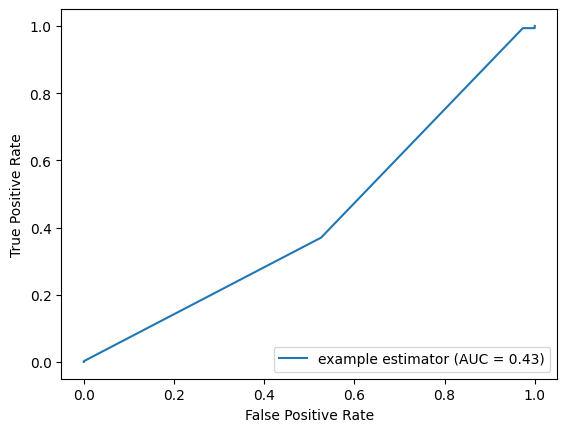

In [86]:
# AUC-ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()
plt.show()

In the last problem, we created a function to get the cooccurrence matrix and calculated the embeddings for each word. We use those embeddings and passed it further into a recurrent neural netowrl.

It is clear that the total number of parameters in the model are high and even with regularization we have 131713 parameters. This resulted in slower execution of the model. Each epoch took around 80 seconds to execute.

This model was sensitive to the number of word embedding values. If we reduce the number of components, the model becomes unstable and returns negative accuracy. I set the number of components to 128, since it shrunk from 9000 to 128.

The final training accuracy of this model is 90.30% and testing accuracy is 92.28%

## Convolutional Neural Network using Glove embeddings

In [87]:
def load_embedding_model():

  wv_from_bin = api.load("glove-wiki-gigaword-200")
  print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))
  return wv_from_bin

In [88]:
##### PLEASE REMOVE THE # TO DOWNLOAD THE EMBEDDING MODEL. DON'T HAVE TO RUN IF THE MODEL IS ALREADY DOWNLOADED.
wv_from_bin = load_embedding_model()

Loaded vocab size 400000


In [89]:
def get_matrix_of_vectors(wv_from_bin, required_words):

  words = list(wv_from_bin.index_to_key)
  print("Shuffling words ...")
  random.seed(225)
  random.shuffle(words)
  words = words[:10000]
  print("Putting %i words into word2ind and matrix M..." % len(words))
  word2ind = {}
  M = []
  curInd = 0
  for w in words:
    try:
      M.append(wv_from_bin.get_vector(w))
      word2ind[w] = curInd
      curInd += 1
    except KeyError:
      continue

  for w in required_words:
    if w in words:
      continue
    try:
      M.append(wv_from_bin.get_vector(w))
      word2ind[w] = curInd
      curInd += 1
    except KeyError:
      continue
  M = np.stack(M)
  print("Done.")
  return M, word2ind

In [90]:
vocab = get_vocab(amazonReviews)
M_glove, word2index_glove = get_matrix_of_vectors(wv_from_bin, vocab)

Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.


In [91]:
def review_embeddings(corpus, word2index, M, n_components = 2):

  # reducing dimensions of M_glove
  M_reduced = reduce_to_k_dim(M, n_components = n_components)
  #M_reduced_averaged = np.average(M_reduced, axis = 1)

  # allocating space to construct review embeddings
  review_embeddings = []
  for review in corpus:
    currReview = []
    for token in review:
      try:
        idx = word2index[token]
        currReview.append(M_reduced[idx])
      except KeyError:
        value = np.zeros(n_components)
        currReview.append(value)

    review_embeddings.append(currReview)


  # padding the review embeddings to have same length
  review_embeddings_padded = []
  max_len = 240
  for embedding in review_embeddings:
    embedding = np.array(embedding)
    diff = max_len - len(embedding)
    if diff>0:
      data = np.pad(embedding,[(0,diff),(0,0)])
      review_embeddings_padded.append(data)
    else:
      embedding = embedding[:max_len]
      review_embeddings_padded.append(embedding)

  review_embeddings_padded = np.stack(review_embeddings_padded)

  return review_embeddings_padded

In [92]:
# Creating the word embeddings for testing, validation and training set.
review_embed_X_train_glv = review_embeddings(X_train, word2index_glove, M_glove, 128)
review_embed_X_val_glv = review_embeddings(X_val, word2index_glove, M_glove, 128)
review_embed_X_test_glv = review_embeddings(X_test, word2index_glove, M_glove, 128)

In [93]:
# define model
model = Sequential()
model.add(Input(shape=(240,128)))
model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 233, 32)           32800     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 116, 32)           0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 3712)              0         
                                                                 
 dense_6 (Dense)             (None, 10)                37130     
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 69941 (273.21 KB)
Trainable params: 69941 (273.21 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [94]:
# compile network
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [95]:
# fit network
model.fit(review_embed_X_train_glv , y_train, batch_size = 20, epochs = 5, validation_data =(review_embed_X_val_glv, y_val) , verbose = 1)

Epoch 1/5
199/199 [==============================] - 8s 40ms/step - loss: 0.3758 - accuracy: 0.8887 - val_loss: 0.3013 - val_accuracy: 0.9029
Epoch 2/5
199/199 [==============================] - 10s 51ms/step - loss: 0.2859 - accuracy: 0.9035 - val_loss: 0.2960 - val_accuracy: 0.9029
Epoch 3/5
199/199 [==============================] - 10s 48ms/step - loss: 0.2733 - accuracy: 0.9063 - val_loss: 0.2855 - val_accuracy: 0.9074
Epoch 4/5
199/199 [==============================] - 7s 38ms/step - loss: 0.2596 - accuracy: 0.9098 - val_loss: 0.2781 - val_accuracy: 0.9074
Epoch 5/5
199/199 [==============================] - 9s 43ms/step - loss: 0.2466 - accuracy: 0.9088 - val_loss: 0.2694 - val_accuracy: 0.9052


In [96]:
score = model.evaluate(review_embed_X_test_glv, y_test, batch_size = 20)

print( "Accuracy: {:0.4}".format( score[1] ))

print( "Loss:", score[0] )

25/25 [==============================] - 0s 11ms/step - loss: 0.2463 - accuracy: 0.9228
Accuracy: 0.9228
Loss: 0.2462574541568756


In [97]:
y_pred = model.predict(review_embed_X_test_glv)
y_pred2 = []
for i in y_pred:
  if i>0.5:
    y_pred2.append(1)
  else:
    y_pred2.append(0)

16/16 [==============================] - 0s 13ms/step


In [98]:
print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.50      0.03      0.05        38
           1       0.92      1.00      0.96       454

    accuracy                           0.92       492
   macro avg       0.71      0.51      0.50       492
weighted avg       0.89      0.92      0.89       492



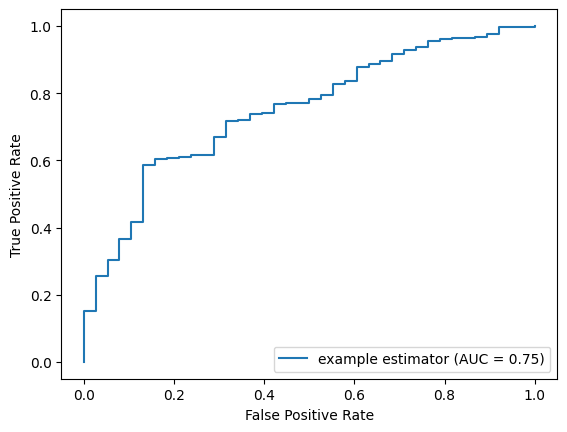

In [99]:
# AUC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()
plt.show()

Similar to our own word embeddings in the first task, we used GLOVE embeddings to vectorize the words. Similar to previous task, using SVD, we truncated the word embeddings to 128 components. This made the data a little easier through the model while keeping it stable.

Convolutional Neural Network using glove embeddings is clearly fasters since the number of total parameters is half compared to Recurrent Neural Network. The total number of final parameters were 69941. This sped up the execution of the model while keeping it stable.

Similar to RNN, we compiled this model usin optimizer and binary crossentropy loss for evaluation. The training accuracy achieved is 90.80% and testing accuracy is 92.28% which is better than RNN for this patricular dataset.


## Conclusion

Considering the data, the choice of model might change. With further parameter tuning this model will perform better and faster. Different word vectorization techniques might also improve model performance given correct parameter tuning.

In comparison to assignment 1 where we used both glove embeddings and cooccurrence matrix to get embeddings, after using logistic regression model and multi layer perceptron we recieved accuracy less than 80%. RNN and CNN both worked better and gave better accuracy and F1 scores.

Looking at the AUC-ROC curve the separability while using CNN is better than RNN. AUC for RNN is 0.45 and for CNN is 0.75. The underlying reason might be the distribution of positive and negative labels.

Since the data is biased, the recall for both the models is not great as the ratio of labels is skewed. With better quality data, we can improve the recall for both models.

